In [95]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error

##Cargar el dataset

In [96]:
data = pd.read_csv("Temp_Asu20092021.csv")

##Convertir la columna 'Fecha' a tipo datetime

In [97]:
data['Fecha'] = pd.to_datetime(data['Fecha'])

##Establecer la columna 'Fecha' como índice

In [98]:
data.set_index('Fecha', inplace=True)

##Filtrar datos desde 2019 en adelante

In [99]:
data = data[data.index.year >= 2019]

##Eliminar filas con valores faltantes

In [100]:
data.dropna(inplace=True)

##Resamplear el conjunto de datos a intervalos diarios
##Calcular la temperatura máxima diaria

In [101]:
daily_max_temperatures = data['Temperatura'].resample('D').max()

##Calcular la temperatura media diaria

In [102]:
daily_mean_temperatures = data['Temperatura'].resample('D').mean()

##Definir la variable objetivo (target) como la temperatura máxima desplazada

In [103]:
salida = daily_max_temperatures.shift(-1)

##Eliminar el último valor de las series debido al `shift(-1)`

In [104]:
daily_max_temperatures = daily_max_temperatures[:-1]
daily_mean_temperatures = daily_mean_temperatures[:-1]
salida = salida[:-1]

##Nuevo Dataframe

In [105]:
data_features = pd.DataFrame(index=daily_max_temperatures.index)

##Mes del año

In [106]:
data_features['Month'] = data_features.index.month

##Día del año

In [107]:
data_features['DayOfYear'] = data_features.index.dayofyear

##Día de la semana

In [108]:
data_features['DayOfWeek'] = data_features.index.dayofweek

##Lag de temperatura máxima

In [109]:
data_features['Lag_max_1'] = daily_max_temperatures.shift(1)
data_features['Lag_max_2'] = daily_max_temperatures.shift(2)

##Lag de temperatura media

In [110]:
data_features['Lag_mean_1'] = daily_mean_temperatures.shift(1)
data_features['Lag_mean_2'] = daily_mean_temperatures.shift(2)

##Diferencias de temperatura

In [111]:
data_features['Diff_max_1'] = daily_max_temperatures.diff(1)
data_features['Diff_mean_1'] = daily_mean_temperatures.diff(1)

##Eliminar filas con valores faltantes en las características y la variable objetivo

In [112]:
data_features.dropna(inplace=True)
salida = salida[data_features.index]

## Definir las características

In [113]:
X = data_features
y = salida


##Normalizar las características

In [114]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

##Dividir los datos en conjuntos de entrenamiento y validación

In [115]:
train_indices = X.index.year <= 2020
val_indices = X.index.year == 2021

X_train, X_val = X_scaled[train_indices], X_scaled[val_indices]
y_train, y_val = y[train_indices], y[val_indices]

##Definir el modelo de regresión Ridge

In [116]:
ridge = Ridge()

##Definir la cuadrícula de parámetros para GridSearch

In [117]:
param_grid = {
    'alpha': [0.01, 0.1, 1.0, 10.0, 100.0] # Regularización L2
}

##Usar GridSearchCV para buscar los mejores hiperparámetros

In [118]:
grid_search = GridSearchCV(estimator=ridge, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error', verbose=1, n_jobs=-1)
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 5 candidates, totalling 15 fits


GridSearchCV(cv=3, estimator=Ridge(), n_jobs=-1,
             param_grid={'alpha': [0.01, 0.1, 1.0, 10.0, 100.0]},
             scoring='neg_mean_squared_error', verbose=1)

##Imprimir los mejores hiperparámetros encontrados

In [119]:
print("Mejores hiperparámetros:")
print(grid_search.best_params_)

Mejores hiperparámetros:
{'alpha': 0.01}


##Evaluar el modelo con los mejores hiperparámetros en el conjunto de validación

In [120]:
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_val)
mse = mean_squared_error(y_val, y_pred)
print(f"Mean Squared Error en validación: {mse}")
print(f"Root Mean Squared Error: {np.sqrt(mse)}")

Mean Squared Error en validación: 17.140659030715756
Root Mean Squared Error: 4.1401279002846945


##Gráfico

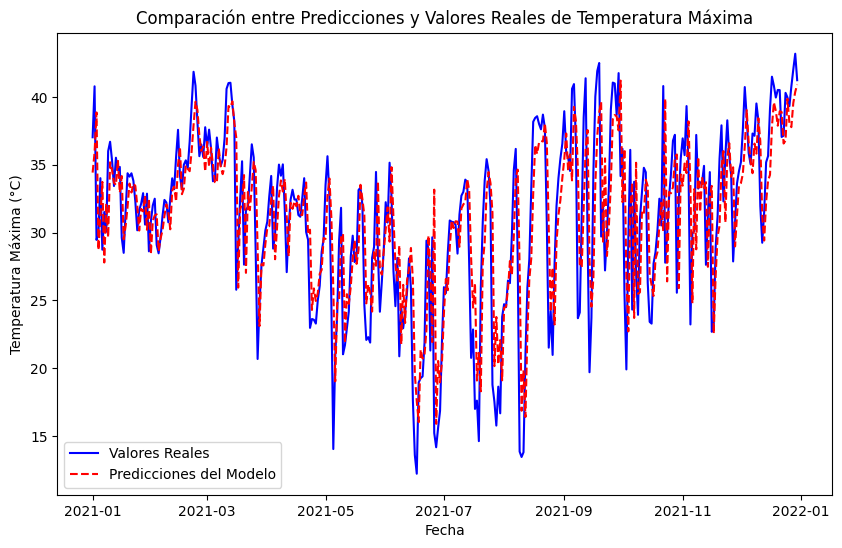

In [121]:
plt.figure(figsize=(10, 6))
plt.plot(y_val.index, y_val, label='Valores Reales', color='blue')
plt.plot(y_val.index, y_pred, label='Predicciones del Modelo', color='red', linestyle='--')
plt.title('Comparación entre Predicciones y Valores Reales de Temperatura Máxima')
plt.xlabel('Fecha')
plt.ylabel('Temperatura Máxima (°C)')
plt.legend()
plt.show()